In [1]:
%load_ext autoreload
%autoreload 2

---------------------------

## Config

In [2]:
import sys

In [3]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'
if project_dir not in sys.path: 
    sys.path.append(project_dir)
from config_analysis import *

---------------------------

- Import dataframe containing **annotation of all samples**

In [4]:
#sample_annotation_file = os.path.join(project_data_dir, 'seq_data', 'sample_annotation.csv')
sample_annotation_file = os.path.join(project_data_dir, 'seq_data', 'file_annotation.csv')
sample_annotation_file

'/gcm-lfs1/pablo/data/rna_silencing/seq_data/file_annotation.csv'

In [5]:
#select_cols = ['sample_id', 'pipeline_type', 'seq_category', 'seq_type',  'mutant_id', 'mutant', 'replicate', 'batch', 'trimmed', 'halic_local_dir']
select_cols = ['sample_id', 'pipeline_type', 'seq_category', 'seq_type',  'mutant_id', 'mutant_name', 'replicate', 'trimmed']

In [6]:
all_samples_df = pd.read_csv(sample_annotation_file, sep="\t", usecols=select_cols)[select_cols]
all_samples_df.head()

,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant_name,replicate,trimmed
0,1022_S2-ChIP-INPUT_1,ChIP,INPUT,S2-ChIP-INPUT,1022,mot2d,1,False
1,1022_S2-ChIP-OIN_1,ChIP,INPUT,S2-ChIP-OIN,1022,mot2d,1,False
2,1022_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,1,False
3,1022_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,2,False
4,1022_S2-RIP_2,RNA,S2-RIP,S2-RIP,1022,mot2d,2,False


In [7]:
all_samples_df.shape

(150, 8)

- **Ignore S2-RIP/S5-RIP samples** for now

In [8]:
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S2-RIP']
all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S5-RIP']
all_samples_df.shape

(149, 8)

- **Ignore S2-ChIP/S5-ChIP samples** for now

In [9]:
#all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S2-ChIP']
all_samples_df = all_samples_df[all_samples_df['seq_type'] != 'S5-ChIP']
all_samples_df.shape

(145, 8)

## Import **Intron Counts** Files: `pombe_intron_count_matrix.csv`

In [10]:
ignore_categories = ['simulated-data', 'INPUT', 'H3K9me2']

In [11]:
#seq_categories = ['INPUT', 'pA-RNA', 'S2-ChIP', 'S2-RIP', 'total-RNA']
seq_categories = all_samples_df['seq_category'].unique() ## wont work for 'simulated-data', 'H3K9me2' yet!
seq_categories = [ss for ss in seq_categories if ss not in ignore_categories]
seq_categories

['S2-ChIP', 'S2-RIP', 'pA-RNA', 'total-RNA']

- Import **Intron Count** Data Frames: (for each `seq_category`)

In [12]:
verbose = False
verbose = True

In [13]:
splice_ratios_summary = {}

In [ ]:
for seq_category in seq_categories:
#for seq_category in seq_categories[1:2]:
    
    # samples in 'seq_category'
    sample_ids = all_samples_df[all_samples_df['seq_category'] == seq_category].sample_id.tolist()
    #sample_ids =[ss for ss in sample_ids if not ('WT' in ss or '1022' in ss or '1023' in ss or '544' in ss or '591' in ss or '260' in ss)]

    ## ----------------
    ## A. Intron Counts
    ## ----------------

    #intron_counts_file = os.path.join(project_dir, 'results', seq_category, 'intron_xp_data/pombe_intron_count_matrix.csv')                      
    intron_counts_file = os.path.join(project_data_dir, 'results', seq_category, 'intron_xp_data/pombe_intron_count_matrix.csv')                      
    
    # load intron counts data - can be that multiple 'intron' map to same 'gene_id'
    #intron_df = pd.read_csv(intron_counts_file, index_col = 'gene_id', sep ='\t')
    intron_df = pd.read_csv(intron_counts_file, sep ='\t')
            #names=['var', os.path.basename(ff).split('.')[0]],
            #index_col = 'var')
    #intron_df.shape # (5372, n_samples + other)
    
    # make sure there are NO missing samples
    in_sample_ids = list(set(sample_ids).intersection(intron_df.columns))
    if len(in_sample_ids) < len(sample_ids):
        print(seq_category)
        excluded_samples = list(set(sample_ids).difference(in_sample_ids))
        print("Excluding some samples! Not present in `pombe_intron_count_matrix.csv`:\n", excluded_samples)
    
    use_cols = in_sample_ids.copy()
    use_cols.extend(['gene_id', 'intron_length', 'bio_type']) # add cols

    # select columns of interest
    intron_df = intron_df[use_cols]
    
    ## 1. Deal with NAs:
    ## - 1.A. Remove NAs - might be not the best idea
    #intron_df = intron_df.dropna(axis=0, how='all') 
    ## - 1.B. Fill NAs with 0s - originate from few reads mapping to introns
    intron_df = intron_df.fillna(0)
    
    ## 2. Group Introns by 'gene_id's
    #intron_df = intron_df.groupby('gene_id').sum()
    intron_df = intron_df.groupby('gene_id').agg(
        {ii: sum if (ii != "bio_type") else 'first' for ii in use_cols}) ## very slow
    #intron_df.shape # (2562, n_samples)

    ## 3. Filter: only use 'mRNA' (protein coding genes)
    #intron_df = intron_df[intron_df['bio_type'] == 'mRNA']
    #intron_df.shape # (2502, n_samples) # missing 10 pseudogenic-transcripts
    # => https://www.pombase.org/faq/how-are-pombase-systematic-ids-determined
    mrna_ids = ['SPAC', 'SPBC', 'SPCC', 'SPAP', 'SPBP', 'SPCP']
    intron_df = intron_df[intron_df.index.str.contains('|'.join(mrna_ids))]
    #intron_df.shape # (2510, n_samples) # missing 2 genes in mitochondrial chromosome
    
    #diff_genes = intron_df_1.index.difference(intron_df_2.index)
    #diff_genes = intron_df_2.index.difference(intron_df_1.index)
    #diff_genes = intron_df_1.index.symmetric_difference(intron_df_2.index)
    #diff_genes_df = intron_df.loc[diff_genes]
    
    ## 4. Norm by `feature_length`: intron_length
    intron_df = intron_df[in_sample_ids].apply(lambda col: col/intron_df['intron_length'])
    
    if (seq_category == 'S2-RIP'):
        import pdb;pdb.set_trace()
    #intron_df[['302_S2-RIP_2', '510_S2-RIP_1', 'WT_S2-RIP_1']].sum(axis=1).sort_values(ascending=False).head(20)
    
    ## --------------
    ## B. Gene Counts
    ## --------------

    #gene_counts_file = os.path.join(project_dir, 'results', seq_category, 'xp_data/pombe_gene_count_matrix.csv')
    gene_counts_file = os.path.join(project_data_dir, 'results', seq_category, 'xp_data/pombe_gene_count_matrix.csv')

    use_cols = in_sample_ids.copy()
    use_cols.extend(['gene_id', 'start', 'end']) # add cols
    
    # load gene counts data
    gene_df = pd.read_csv(gene_counts_file, usecols=use_cols, index_col = 'gene_id', sep ='\t')
            #names=['var', os.path.basename(ff).split('.')[0]],
            #index_col = 'var')
    
    # make sure there are NO missing samples
    in_sample_ids = list(set(sample_ids).intersection(gene_df.columns))
    if len(in_sample_ids) < len(sample_ids):
        print(seq_category)
        excluded_samples = list(set(sample_ids).difference(in_sample_ids))
        print("Excluding some samples! Not present in `pombe_gene_count_matrix.csv`:\n", excluded_samples)
    
    ## 5. Filter: only use genes containing introns (present in 'intron_df')
    gene_ids = intron_df.index
    gene_df = gene_df.loc[gene_ids]
    gene_df.shape # ?

    ## 6. Norm by `feature_length`: gene_length
    # use 'gene_length' the whole region spanned by the gene: (including Introns)
    gene_df['gene_length'] = gene_df['end'] - gene_df['start'] + 1
    gene_df = gene_df[in_sample_ids].apply(lambda col: col/gene_df['gene_length'])
    
    ## 7. Deal with NAs:
    ## - 6.A. Remove NAs - will be handled by df.div()
    #gene_df = gene_df.dropna(axis=0, how='all') 
    ## - 6.B. Fill NAs with 0s - might be not the best idea will be dividing by 0
    #gene_df = gene_df.fillna(0)

    if (seq_category == 'pA-RNA'):
        import pdb;pdb.set_trace()
    #gene_df[['302_S2-RIP_2', '510_S2-RIP_1', 'WT_S2-RIP_1']].sum(axis=1).sort_values(ascending=False).head(20)
    
    ## --------------------------
    ## Splice Ratio - Intron/Gene
    ## --------------------------
    
    if verbose:
        print(
            '\n',
            40 * '-', 
            '\n {}:\n \tintron_df: {}\n \tgene_df: {}\n'.format(seq_category, intron_df.shape, gene_df.shape),
            40 * '-')

    ## 8. Compute ratio - DataFrames have already been prepared (5298, n_samples)
    splice_ratio = intron_df.div(gene_df)

    ## 9. Summarize - by sample
    splice_ratio = splice_ratio.describe()

    # change samples to rows: ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    splice_ratio = splice_ratio.transpose()

    # index to column and rename to 'sample_id'
    splice_ratio = splice_ratio.reset_index(drop=False).rename(columns = {'index':'sample_id'})  

    splice_ratios_summary[seq_category] = splice_ratio


 ---------------------------------------- 
 S2-ChIP:
 	intron_df: (2510, 31)
 	gene_df: (2510, 31)
 ----------------------------------------
> <ipython-input-19-2547a89a91dc>(72)<module>()
-> gene_counts_file = os.path.join(project_data_dir, 'results', seq_category, 'xp_data/pombe_gene_count_matrix.csv')


(Pdb)  intron_df[['302_S2-RIP_2', '510_S2-RIP_1', 'WT_S2-RIP_1']].sum(axis=1).sort_values(ascending=False)


gene_id
SPAC6F6.03c      21.319307
SPAC6B12.15       9.840000
SPAC29E6.08       8.928382
SPBP8B7.16c       8.883019
SPBC660.16        7.529218
                   ...    
SPBC30D10.02      0.000000
SPBC30D10.03c     0.000000
SPAC30D11.09      0.000000
SPAC30D11.08c     0.000000
SPCPJ732.03       0.000000
Length: 2510, dtype: float64


(Pdb)  intron_df[['302_S2-RIP_2', '510_S2-RIP_1', 'WT_S2-RIP_1']].sum(axis=1).sort_values(ascending=False).head()


gene_id
SPAC6F6.03c    21.319307
SPAC6B12.15     9.840000
SPAC29E6.08     8.928382
SPBP8B7.16c     8.883019
SPBC660.16      7.529218
dtype: float64


(Pdb)  intron_df[['302_S2-RIP_2', '510_S2-RIP_1', 'WT_S2-RIP_1']].sum(axis=1).sort_values(ascending=False).head(20)


gene_id
SPAC6F6.03c      21.319307
SPAC6B12.15       9.840000
SPAC29E6.08       8.928382
SPBP8B7.16c       8.883019
SPBC660.16        7.529218
SPBC3B9.13c       5.960938
SPCC830.09c       5.551724
SPBC18H10.12c     5.453515
SPCC23B6.01c      5.106383
SPAC8C9.14        4.987607
SPAC16.02c        4.616505
SPAC15E1.03       4.605263
SPAC24C9.06c      4.370429
SPBC16G5.14c      4.281746
SPAC4D7.10c       4.280303
SPBC119.02        4.266667
SPAC1639.01c      4.208754
SPAC5D6.01        4.142857
SPAC1805.13       4.053279
SPBC1685.10       4.033058
dtype: float64


In [ ]:
print(os.path.join(out_dir, 'FigureS1-B_forward.png'))

scatter_plot(df, 'WT_S2-RIP', 'WT_pA-RNA',
             out_dir,
             'FigureS1-B_forward.png',
             regressor=True,
             #annotate=False,
             annotate=True,
             #include_mat_locus_vis = include_mat_locus_vis,
             #include_mat_locus_vis = True,
             include_mat_locus_vis = False,
             xlabel='Pol II RIP\n$\mathrm{log_2TPM(wt)}$',
             ylabel='pA RNA\n$\mathrm{log_2TPM(wt)}$', 
             xlim=14, ylim=14,
             #ribo_color='dimgray'
            )

/gcm-lfs1/pablo/data/rna_silencing/results/Ratios/Plots_29-03-21/Figure-S1/FigureS1-B_forward.png
> /home/pmonteagudo/workspace/silencing_project/pyRNAdeg/viz_strands.py(548)scatter_plot_gene_params()
-> if ('plus' in nn):


(Pdb)  c


> /home/pmonteagudo/workspace/silencing_project/pyRNAdeg/viz_strands.py(548)scatter_plot_gene_params()
-> if ('plus' in nn):


(Pdb)  
(Pdb)  



324_S2-RIP_3     137.401551
491_S2-RIP_3     143.826639
1022_S2-RIP_4    145.326684
302_S2-RIP_1     149.896954
80_S2-RIP_3      152.293262
302_S2-RIP_3     156.906743
324_S2-RIP_1     172.845930
544_S2-RIP_1     178.058034
491_S2-RIP_1     195.014542
1022_S2-RIP_3    203.405633
301_S2-RIP_1     218.135854
544_S2-RIP_3     224.427207
WT_S2-RIP_1      263.687148
510_S2-RIP_1     267.267288
302_S2-RIP_2     370.236112

- Concatenate all different sequencing sample dataframes into one:

In [15]:
#splice_ratios_summary

In [16]:
col_order = ['sample_id', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

In [17]:
splice_ratio_df = pd.concat(splice_ratios_summary, ignore_index=True, sort = True)[col_order]
splice_ratio_df.head()

,sample_id,count,mean,std,min,25%,50%,75%,max
0,504_S2-ChIP_2,2505.0,0.577553,0.683769,0.0,0.059226,0.371973,0.828184,5.278150
1,1168_S2-ChIP_2,2503.0,0.486137,0.645938,0.0,0.000000,0.273463,0.691513,8.587702
2,80_S2-ChIP_2,2505.0,0.502099,0.630799,0.0,0.000000,0.294592,0.741463,5.327656
3,1022_S2-ChIP_2,2505.0,0.464741,0.560996,0.0,0.052847,0.279774,0.658087,4.837845
4,491_S2-ChIP_3,2505.0,0.627903,0.651501,0.0,0.104380,0.455308,0.911365,5.660807


In [18]:
splice_ratio_df.shape

(110, 9)

- Merge with sample **annotation** dataframe

In [19]:
splice_ratio_df = pd.merge(all_samples_df, splice_ratio_df, on='sample_id')

In [20]:
splice_ratio_df.head()

,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant_name,replicate,trimmed,count,mean,std,min,25%,50%,75%,max
0,1022_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,1,False,2504.0,0.472089,0.606093,0.0,0.000000,0.264097,0.683011,6.635846
1,1022_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,2,False,2505.0,0.464741,0.560996,0.0,0.052847,0.279774,0.658087,4.837845
2,1022_S2-RIP_2,RNA,S2-RIP,S2-RIP,1022,mot2d,2,False,2471.0,0.396025,0.969131,0.0,0.000000,0.000000,0.276412,11.743013
3,1022_S2-RIP_3,RNA,S2-RIP,S2-RIP,1022,mot2d,3,False,2497.0,0.422064,0.570048,0.0,0.000000,0.221759,0.636267,5.152266
4,1022_S2-RIP_4,RNA,S2-RIP,S2-RIP,1022,mot2d,4,False,2491.0,0.342219,0.570551,0.0,0.000000,0.000000,0.495971,5.051780


In [21]:
splice_ratio_df.shape

(110, 16)

- Store dataframe containing annotation of all samples:

In [22]:
splice_ratio_file = os.path.join(project_dir, 'results', 'introns_splice_ratio.csv')
splice_ratio_file

'/home/pmonteagudo/workspace/silencing_project/results/introns_splice_ratio.csv'

In [23]:
splice_ratio_df.to_csv(splice_ratio_file, sep="\t", index=False)

---------------------------

# Visualization

In [24]:
import seaborn as sns

In [25]:
import matplotlib.pyplot as plt

- Prepare Data Frame into tidy format for visualization using seaborn

In [26]:
id_vars = select_cols.copy()
#id_vars.append('star_log_file')

In [27]:
#id_vars

In [28]:
splice_ratio_tidy_df = pd.melt(splice_ratio_df, id_vars = id_vars, var_name = 'splice_ratio')
#splice_ratio_tidy_df = splice_ratio_tidy_df.astype({'value':'float64'})

In [29]:
splice_ratio_tidy_df.head()

,sample_id,pipeline_type,seq_category,seq_type,mutant_id,mutant_name,replicate,trimmed,splice_ratio,value
0,1022_S2-ChIP_1,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,1,False,count,2504.0
1,1022_S2-ChIP_2,ChIP,S2-ChIP,S2-ChIP,1022,mot2d,2,False,count,2505.0
2,1022_S2-RIP_2,RNA,S2-RIP,S2-RIP,1022,mot2d,2,False,count,2471.0
3,1022_S2-RIP_3,RNA,S2-RIP,S2-RIP,1022,mot2d,3,False,count,2497.0
4,1022_S2-RIP_4,RNA,S2-RIP,S2-RIP,1022,mot2d,4,False,count,2491.0


In [30]:
splice_ratio_tidy_df.shape

(880, 10)

- Variables that can be used for plotting

In [31]:
plot_vars = splice_ratio_tidy_df['splice_ratio'].unique()
plot_vars

array(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
      dtype=object)

## Average Splice Ratio - `intron/gene`

In [32]:
plot_abs_vars = ['mean']

In [33]:
splice_ratio_plot = splice_ratio_tidy_df[splice_ratio_tidy_df["splice_ratio"].isin(plot_abs_vars)]
#splice_ratio_plot

In [34]:
## Filter INPUT/OIN: Ratio to high!
splice_ratio_plot = splice_ratio_plot[~splice_ratio_plot["seq_type"].isin(['S2-ChIP-INPUT', 'S2-ChIP-OIN'])]
#trna_plot

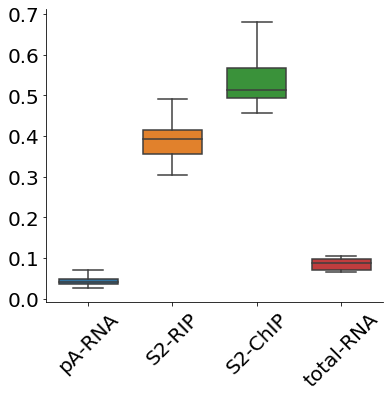

In [35]:
box_plot = sns.catplot(x="seq_type", y="value",
                       hue="seq_category", col="splice_ratio",
                       order=['pA-RNA', 'S2-RIP', 'S2-ChIP', 'total-RNA'],
                       hue_order=['pA-RNA', 'S2-RIP', 'S2-ChIP', 'total-RNA'],
                       data=splice_ratio_plot, kind="box",
                       aspect= 1.1,
                       dodge = False,
                       width = 0.7,
                       legend = False, 
                       #showfliers=True) 
                       showfliers=False) ## remove outliers

box_plot.set_xticklabels(rotation=45, fontsize=20)
box_plot.set_yticklabels(fontsize=20)

#box_plot.set_xlabels('Sequencing Assay', fontsize=35) # not set_label
#box_plot.set_ylabels('Splice Ratio', fontsize=35)
box_plot.set_xlabels('') # not set_label
box_plot.set_ylabels('')

#box_plot._legend.set_title("Sequencing Assay")
#plt.setp(box_plot._legend.get_texts(), fontsize='22') # for legend text
#plt.setp(box_plot._legend.get_title(), fontsize='32') # for legend title

axes = box_plot.axes.flatten()
axes[0].set_title("")

splice_ratio_fig = os.path.join(project_dir, 'results', 'splice_ratio.pdf')
box_plot.savefig(splice_ratio_fig)

In [36]:
splice_ratio_fig

'/home/pmonteagudo/workspace/silencing_project/results/splice_ratio.pdf'

## Intron length distribution

- Import **Gene Information Table**: GDF file

In [37]:
gdf_file = os.path.join(project_data_dir, 'annotation/gff_v2/Schizosaccharomyces_pombe_all_chromosomes.extended.features.csv')

In [38]:
gdf = pd.read_csv(gdf_file, index_col = 'gene_id', sep ='\t')

In [39]:
gdf.head()

,seqid,source,type,start,end,score,strand,phase,ID,Name,gene_name,transcript_id,cds_length,utr_length,intron_length,bio_type,gene_length,transcript_length,category
gene_id,,,,,,,,,,,,,,,,,,,
SPAC1002.01,I,PomBase,gene,1798347,1799015,.,+,.,SPAC1002.01,mrx11,mrx11,SPAC1002.01.1,540.0,NaN,129.0,mRNA,669,540.0,gene
SPAC1002.02,I,PomBase,gene,1799061,1800053,.,+,.,SPAC1002.02,pom34,pom34,SPAC1002.02.1,690.0,303.0,NaN,mRNA,993,993.0,gene
SPAC1002.03c,I,PomBase,gene,1799915,1803141,.,-,.,SPAC1002.03c,gls2,gls2,SPAC1002.03c.1,2772.0,455.0,NaN,mRNA,3227,3227.0,gene
SPAC1002.04c,I,PomBase,gene,1803624,1804491,.,-,.,SPAC1002.04c,taf11,taf11,SPAC1002.04c.1,600.0,268.0,NaN,mRNA,868,868.0,gene
SPAC1002.05c,I,PomBase,gene,1804548,1806797,.,-,.,SPAC1002.05c,jmj2,jmj2,SPAC1002.05c.1,2148.0,102.0,NaN,mRNA,2250,2250.0,gene


In [40]:
gdf.shape

(7018, 19)

- Prepare **intron length** information

In [41]:
id_vars = ['intron_length', 'gene_length']

In [42]:
# use 'gene_length' as the whole region spanned by the gene: (including Introns)
gdf['gene_length'] = gdf['end'] - gdf['start'] + 1
    
# only use Protein Coding genes for Intron analysis
gdf = gdf[gdf['bio_type'] == 'mRNA'][id_vars]
# => https://www.pombase.org/faq/how-are-pombase-systematic-ids-determined
mrna_ids = ['SPAC', 'SPBC', 'SPCC', 'SPAP', 'SPBP', 'SPCP']
gdf = gdf[gdf.index.str.contains('|'.join(mrna_ids))]
    
# drop gene entries that do not have introns:
gdf = gdf.dropna(axis=0, how='all', subset=['intron_length'])

# compute intron/gene length ratio
gdf['ratio_intron_gene_length'] = gdf['intron_length'] / gdf['gene_length']

gdf.shape

(2500, 3)

Introns that are **longer than genes** (not possible by construction)

In [43]:
gdf[gdf['ratio_intron_gene_length'] >= 1]

,intron_length,gene_length,ratio_intron_gene_length
gene_id,,,


- Prepare Data Frame into tidy format for visualization using `seaborn`
    - var: `length`
        - 'intron_length'
        - 'gene_length'
        - 'ratio_intron_gene_length'

In [44]:
gdf_intron_tidy_df = pd.melt(gdf, var_name = 'length')

In [45]:
gdf_intron_tidy_df.head()

,length,value
0,intron_length,129.0
1,intron_length,155.0
2,intron_length,493.0
3,intron_length,251.0
4,intron_length,522.0


In [46]:
gdf_intron_tidy_df.shape

(7500, 2)

- Variables that can be used for plotting

In [47]:
plot_vars = gdf_intron_tidy_df['length'].unique()
plot_vars

array(['intron_length', 'gene_length', 'ratio_intron_gene_length'],
      dtype=object)

## Average Intron vs Gene length

- **Plot**: Intron length and Gene length

In [48]:
plot_abs_vars = ['intron_length', 'gene_length']

In [49]:
gdf_intron_plot = gdf_intron_tidy_df[gdf_intron_tidy_df["length"].isin(plot_abs_vars)]
gdf_intron_plot = gdf_intron_plot.astype({'value':'float64'})

In [50]:
#gdf_intron_plot

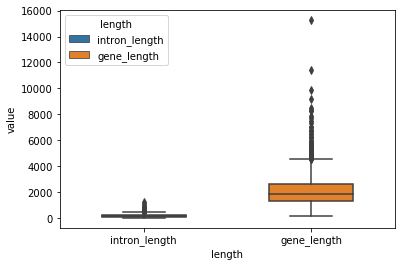

In [51]:
#box_plot = sns.pairplot(gdf_intron_plot, hue="length")
box_plot = sns.boxplot(x="length", y="value", hue="length", 
                       data = gdf_intron_plot,
                       dodge = False,
                       width = 0.5
                      )

#box_plot.set_xticklabels(rotation=45)

#splice_ratio_fig = os.path.join(project_dir, 'results', 'splice_ratio.pdf')
#box_plot.savefig(splice_ratio_fig)

- **Plot**: Intron/Gene length Ratio

In [52]:
plot_abs_vars = ['ratio_intron_gene_length']

In [53]:
gdf_intron_plot = gdf_intron_tidy_df[gdf_intron_tidy_df["length"].isin(plot_abs_vars)]
gdf_intron_plot = gdf_intron_plot.astype({'value':'float64'})

In [54]:
#gdf_intron_plot

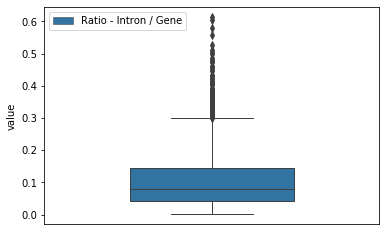

In [55]:
# EDIT: I Needed to add the fig
fig, ax1 = plt.subplots(1,1)

# EDIT: 
# T.W.' answer said: "create with hue but without legend" <- # I needed to include it!
# So, removed: legend=False
#box_plot = sns.pairplot(gdf_intron_plot, hue="length")
box_plot = sns.boxplot(x="length", y="value", hue="length", 
                       data = gdf_intron_plot,
                       ax=ax1,
                       width=0.5,
                       linewidth=1
                      )

# EDIT: 
# Removed 'ax' from T.W.'s answer here aswell:
#box = box_plot.get_position()
#box_plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the left side
handles, _ = box_plot.get_legend_handles_labels()
box_plot.legend(handles, ["Ratio - Intron / Gene"], loc='upper left', ncol=1)
                #bbox_to_anchor=(1.25, 0.5))

box_plot.get_xaxis().set_visible(False)
#box_plot.set_xticklabels(rotation=45)


#splice_ratio_fig = os.path.join(project_dir, 'results', 'splice_ratio.pdf')
#box_plot.savefig(splice_ratio_fig)

In [56]:
## 